# MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles
This is the code for the paper entitled "[**MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles**](https://arxiv.org/pdf/2105.13289.pdf)" accepted in IEEE Internet of Things Journal.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, and A. Shami, “MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles,” IEEE Internet of Things Journal, vol. 9, no. 1, pp. 616-632, Jan.1, 2022.

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

### split train set and test set

In [3]:
# Read the sampled dataset
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [4]:
df=df.dropna()

In [5]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [7]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [8]:
features = df.dtypes[df.dtypes != 'object'].index

In [9]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [10]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [11]:
X_fs = df[fs].values

In [12]:
X_fs.shape

(26769, 45)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [13]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [14]:
X_fss = fcbf.fit_transform(X_fs,y)

In [15]:
X_fss.shape

(26769, 20)

### Re-split train & test sets after feature selection

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [17]:
X_train.shape

(21415, 20)

In [18]:
pd.Series(y_train).value_counts()

0    14557
3     2418
6     1744
1     1573
5     1005
2       89
4       29
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [22]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={2:1000,4:1000})

In [23]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [24]:
pd.Series(y_train).value_counts()

0    14557
3     2418
6     1744
1     1573
5     1005
4     1000
2     1000
Name: count, dtype: int64

In [25]:
criteria = ['gini', 'entropy']

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9934628315278297
Precision of XGBoost: 0.9935098770737718
Recall of XGBoost: 0.9934628315278297
F1-score of XGBoost: 0.9934675692546018
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3640
           1       0.99      0.99      0.99       393
           2       0.96      1.00      0.98        22
           3       0.99      0.99      0.99       605
           4       1.00      0.86      0.92         7
           5       1.00      0.99      1.00       251
           6       0.97      0.99      0.98       436

    accuracy                           0.99      5354
   macro avg       0.99      0.97      0.98      5354
weighted avg       0.99      0.99      0.99      5354



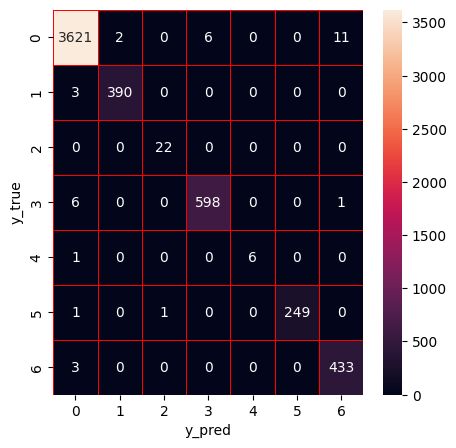

In [26]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [27]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:10<00:00,  1.88trial/s, best loss: -0.9970115801270079]
XGBoost: Hyperopt estimated optimum {'learning_rate': -1.1577829633790846, 'max_depth': 25.0, 'n_estimators': 75.0}


Accuracy of XGBoost: 0.9970115801270079
Precision of XGBoost: 0.9970287974989748
Recall of XGBoost: 0.9970115801270079
F1-score of XGBoost: 0.9970149781795179
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3640
           1       0.99      1.00      1.00       393
           2       0.96      1.00      0.98        22
           3       1.00      1.00      1.00       605
           4       1.00      1.00      1.00         7
           5       1.00      0.99      1.00       251
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5354
   macro avg       0.99      1.00      0.99      5354
weighted avg       1.00      1.00      1.00      5354



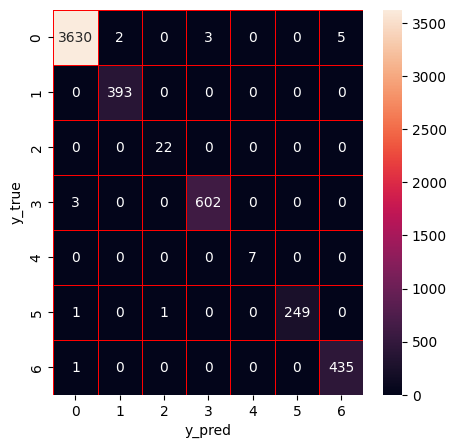

In [29]:
xg = xgb.XGBClassifier(learning_rate=1.1577829633790846, n_estimators=75, max_depth =25)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [30]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9958909226746357
Precision of RF: 0.995902371132844
Recall of RF: 0.9958909226746357
F1-score of RF: 0.9958609339002981
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3640
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        22
           3       1.00      0.99      0.99       605
           4       1.00      0.71      0.83         7
           5       1.00      0.99      0.99       251
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5354
   macro avg       1.00      0.96      0.97      5354
weighted avg       1.00      1.00      1.00      5354



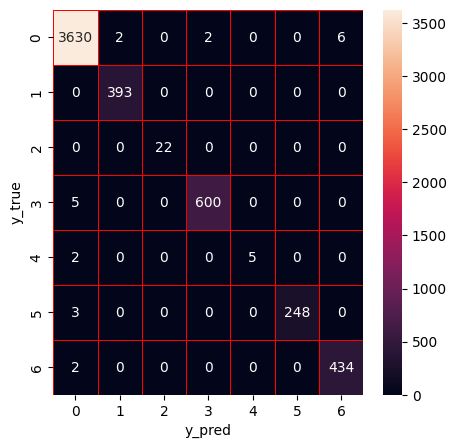

In [31]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [32]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [01:33<00:00,  4.69s/trial, best loss: -0.9962644751587598]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 49.0, 'max_features': 10.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 116.0}


Accuracy of RF: 0.9964512514008218
Precision of RF: 0.9964727262756796
Recall of RF: 0.9964512514008218
F1-score of RF: 0.996452668858117
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3640
           1       0.99      1.00      1.00       393
           2       0.96      1.00      0.98        22
           3       1.00      0.99      1.00       605
           4       1.00      1.00      1.00         7
           5       1.00      0.98      0.99       251
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5354
   macro avg       0.99      1.00      0.99      5354
weighted avg       1.00      1.00      1.00      5354



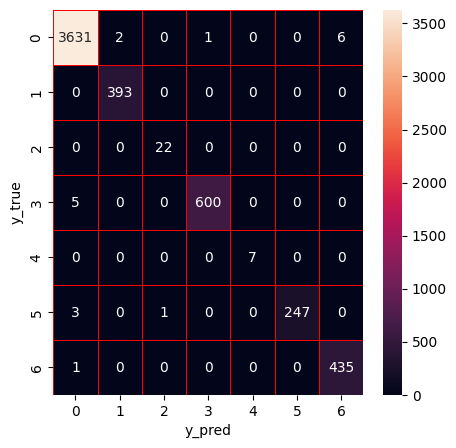

In [37]:
rf_hpo = RandomForestClassifier(n_estimators =116, min_samples_leaf = 1, max_depth = 49, min_samples_split = 2, max_features = 10, criterion = criteria[best['criterion']])
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [38]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9938363840119537
Precision of DT: 0.9938789446922118
Recall of DT: 0.9938363840119537
F1-score of DT: 0.9938445680214824
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3640
           1       0.99      1.00      0.99       393
           2       0.96      1.00      0.98        22
           3       0.99      1.00      0.99       605
           4       0.71      0.71      0.71         7
           5       0.99      0.99      0.99       251
           6       0.98      1.00      0.99       436

    accuracy                           0.99      5354
   macro avg       0.95      0.96      0.95      5354
weighted avg       0.99      0.99      0.99      5354



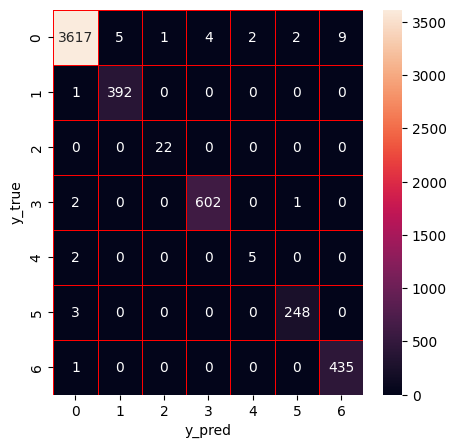

In [39]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [40]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:03<00:00, 13.34trial/s, best loss: -0.9951438177063877]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 23.0, 'max_features': 12.0, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0}


Accuracy of DT: 0.9908479641389615
Precision of DT: 0.9909251620567149
Recall of DT: 0.9908479641389615
F1-score of DT: 0.9908559912791498
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3640
           1       0.98      0.99      0.99       393
           2       0.88      1.00      0.94        22
           3       0.99      0.99      0.99       605
           4       1.00      1.00      1.00         7
           5       1.00      0.97      0.98       251
           6       0.98      0.98      0.98       436

    accuracy                           0.99      5354
   macro avg       0.98      0.99      0.98      5354
weighted avg       0.99      0.99      0.99      5354



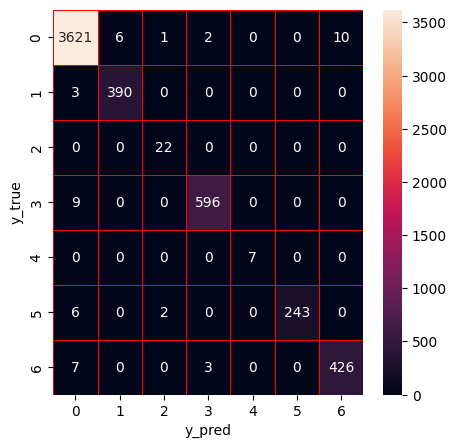

In [41]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 23, min_samples_split = 3, max_features = 12, criterion = criteria[best['criterion']])
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [42]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9955173701905118
Precision of ET: 0.995528973450554
Recall of ET: 0.9955173701905118
F1-score of ET: 0.9954429829149765
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3640
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        22
           3       0.99      0.99      0.99       605
           4       1.00      0.57      0.73         7
           5       1.00      0.99      0.99       251
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5354
   macro avg       1.00      0.93      0.96      5354
weighted avg       1.00      1.00      1.00      5354



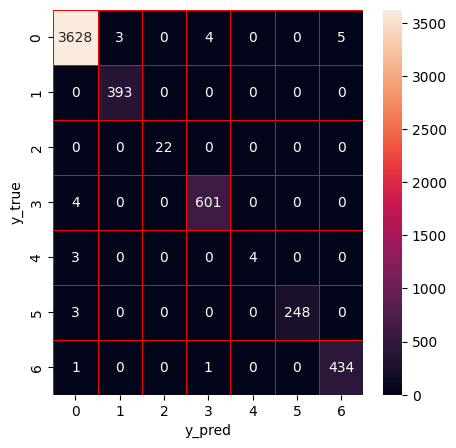

In [43]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [44]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:23<00:00,  1.19s/trial, best loss: -0.9932760552857677]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 34.0, 'max_features': 16.0, 'min_samples_leaf': 5.0, 'min_samples_split': 9.0, 'n_estimators': 63.0}


Accuracy of ET: 0.9788942846469929
Precision of ET: 0.9790825534615621
Recall of ET: 0.9788942846469929
F1-score of ET: 0.9787678455329613
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3640
           1       0.93      1.00      0.97       393
           2       1.00      0.91      0.95        22
           3       0.98      0.98      0.98       605
           4       1.00      0.57      0.73         7
           5       1.00      0.99      0.99       251
           6       0.96      0.91      0.94       436

    accuracy                           0.98      5354
   macro avg       0.98      0.91      0.93      5354
weighted avg       0.98      0.98      0.98      5354



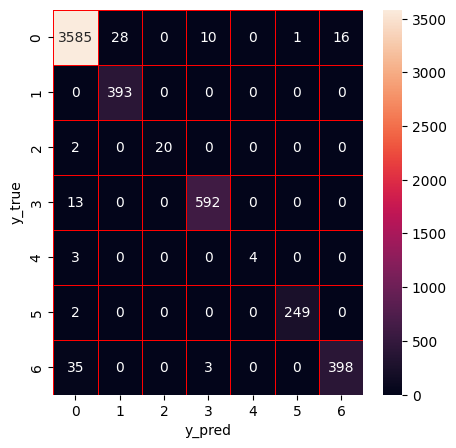

In [45]:
et_hpo = ExtraTreesClassifier(n_estimators = 63, min_samples_leaf = 5, max_depth = 34, min_samples_split = 9,criterion=criteria[best['criterion']])
et_hpo.fit(X_train,y_train)
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [46]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [47]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,3,3,0,3
4,0,0,0,0


In [48]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [49]:
dt_train.shape

(23297, 1)

In [50]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9964512514008218
Precision of Stacking: 0.9964727262756796
Recall of Stacking: 0.9964512514008218
F1-score of Stacking: 0.996452668858117
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3640
           1       0.99      1.00      1.00       393
           2       0.96      1.00      0.98        22
           3       1.00      0.99      1.00       605
           4       1.00      1.00      1.00         7
           5       1.00      0.98      0.99       251
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5354
   macro avg       0.99      1.00      0.99      5354
weighted avg       1.00      1.00      1.00      5354



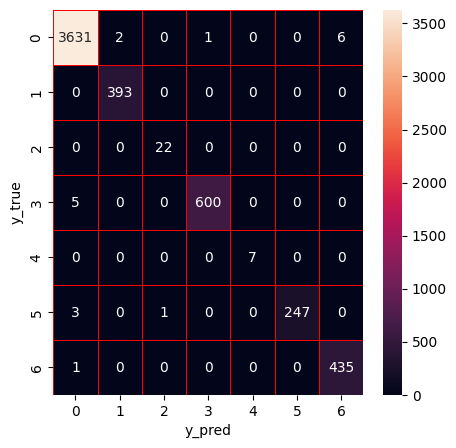

In [51]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [52]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:02<00:00,  7.42trial/s, best loss: -0.9964512514008218]
XGBoost: Hyperopt estimated optimum {'learning_rate': 1.8632688556617412, 'max_depth': 78.0, 'n_estimators': 75.0}


Accuracy of XGBoost: 0.9964512514008218
Precision of XGBoost: 0.9964727262756796
Recall of XGBoost: 0.9964512514008218
F1-score of XGBoost: 0.996452668858117
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3640
           1       0.99      1.00      1.00       393
           2       0.96      1.00      0.98        22
           3       1.00      0.99      1.00       605
           4       1.00      1.00      1.00         7
           5       1.00      0.98      0.99       251
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5354
   macro avg       0.99      1.00      0.99      5354
weighted avg       1.00      1.00      1.00      5354



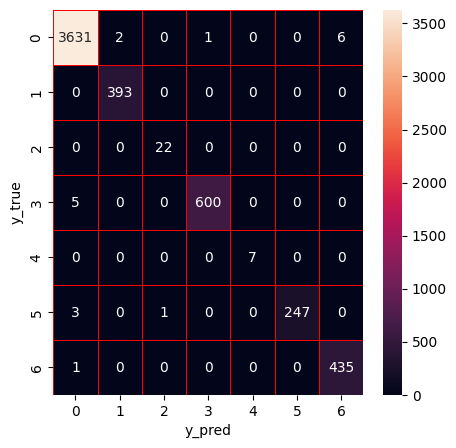

In [53]:
xg = xgb.XGBClassifier(learning_rate= 1.8632688556617412, n_estimators = 75, max_depth = 78)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [54]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [55]:
df.Label.value_counts()

Label
0    18197
3     3023
6     2180
1     1966
5     1256
2      111
4       36
Name: count, dtype: int64

In [56]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [57]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [100]:
df1 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [101]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [102]:
df1.Label.value_counts()

Label
0    18197
1     7316
Name: count, dtype: int64

In [103]:
df2.Label.value_counts()

Label
1    1256
Name: count, dtype: int64

In [104]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [105]:
df2.Label.value_counts()

Label
1    1256
0    1253
Name: count, dtype: int64

In [106]:
df = pd.concat([df1, df2])

In [107]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

0    19450
1     8572
Name: count, dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [108]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [109]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [110]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [111]:
X_fs = df[fs].values

In [112]:
X_fs.shape

(28022, 50)

In [113]:
X_fs

array([[-0.42341759, -0.35611516,  2.08161098, ..., -0.06612584,
        -0.08548923, -0.11810341],
       [-0.42341759, -0.35611516,  2.39936582, ..., -0.06612584,
        -0.08548923, -0.11810341],
       [-0.42341759, -0.35611516,  2.364132  , ..., -0.06612584,
        -0.08548923, -0.11810341],
       ...,
       [ 1.62866193, -0.34342707, -0.53403649, ..., -0.06612584,
        -0.08548923, -0.11810341],
       [ 1.37349389, -0.36776168, -0.53403649, ..., -0.06612584,
        -0.08548923, -0.11810341],
       [-0.42341759, -0.36198576,  0.53643772, ..., -0.06612584,
        -0.08548923, -0.11810341]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [114]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [115]:
X_fss = fcbf.fit_transform(X_fs,y)

In [116]:
X_fss.shape

(28022, 20)

In [117]:
X_fss

array([[-0.42341759, -0.35611516,  3.9955928 , ...,  0.06245033,
        -0.41638529, -0.28017966],
       [-0.42341759, -0.35611516,  3.9955928 , ...,  0.06245033,
        -0.41616199, -0.28015013],
       [-0.42341759, -0.35611516,  3.9955928 , ...,  0.06452729,
        -0.41652835, -0.28013203],
       ...,
       [ 1.62866193, -0.34342707, -0.49791655, ..., -0.23504473,
        -0.42281854, -0.28103051],
       [ 1.37349389, -0.36776168,  0.00446942, ..., -0.23504473,
        -0.42281845, -0.28103017],
       [-0.42341759, -0.36198576,  0.00662588, ...,  0.05534901,
        -0.41462312, -0.27517742]])

####  kernel principal component analysis (KPCA)

In [118]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [119]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [120]:
pd.Series(y_train).value_counts()

0    18197
1     7316
Name: count, dtype: int64

In [121]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [122]:
pd.Series(y_train).value_counts()

1    18225
0    18197
Name: count, dtype: int64

In [123]:
pd.Series(y_test).value_counts()

1    1256
0    1253
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [124]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [125]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [126]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.61      0.84      0.71      1253
           1       0.74      0.46      0.57      1256

    accuracy                           0.65      2509
   macro avg       0.68      0.65      0.64      2509
weighted avg       0.68      0.65      0.64      2509

0.6500597847748106
[[1054  199]
 [ 679  577]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [127]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']

    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.6193702670386608
43 0.42407333599043445
43 0.6791550418493424
43 0.42287764049422083
32 0.45994420087684335
20 0.4691111996811479
16 0.45595854922279794
5 0.4619370267038661
15 0.4631327222000797
25 0.4503786369071343
42 0.4631327222000797
8 0.48385811080111596
8 0.4830609804703069
13 0.47907532881626147
4 0.41450777202072536
50 0.6528497409326425
3 0.4101235552012754
48 0.44599442008768436
45 0.6771622160223196
38 0.6512554802710243
18.900968074798584
Best score=0.6792
Best parameters: n_clusters=43


In [128]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']),
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']

    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else:
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

9 0.4603427660422479                                  
36 0.6456755679553607                                                           
48 0.4679155041849342                                                            
49 0.41490633718612996                                                           
24 0.4774810681546433                                                            
41 0.46113989637305697                                                           
3 0.41052212036667995                                                            
50 0.4320446392985253                                                            
6 0.4619370267038661                                                             
42 0.4483858110801116                                                            
43 0.6727779992028696                                                             
29 0.4675169390195297                                                             
47 0.4348345954563571                     

In [129]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.61      0.92      0.73      1253
           1       0.83      0.40      0.54      1256

    accuracy                           0.66      2509
   macro avg       0.72      0.66      0.64      2509
weighted avg       0.72      0.66      0.64      2509

0.6612196094061379
[[1151  102]
 [ 748  508]]


### Apply the CL-k-means model with biased classifiers

In [133]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [139]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings("ignore") # To suppress warnings from scikit-learn

def Anomaly_IDS(X_train, X_test, y_train, y_test, n, b=100):
    # CL-k-means for initial clustering
    # Use 'n_init="auto"' to suppress FutureWarning in newer scikit-learn versions
    # Added random_state for reproducibility
    km_cluster = MiniBatchKMeans(n_clusters=n, batch_size=b, random_state=0, n_init="auto")
    result_train_cluster = km_cluster.fit_predict(X_train)
    result_test_cluster = km_cluster.predict(X_test)

    # Cluster labeling based on y_train
    a_counts = np.zeros(n) # counts of label 1 (anomaly) in each cluster
    b_counts = np.zeros(n) # counts of label 0 (normal) in each cluster

    for v in range(0, n):
        for i in range(0, len(y_train)):
            if result_train_cluster[i] == v:
                if y_train[i] == 1:
                    a_counts[v] += 1
                else:
                    b_counts[v] += 1

    list_normal_clusters = [] # Clusters where normal (0) is dominant or equal
    list_anomaly_clusters = [] # Clusters where anomaly (1) is dominant

    for v in range(0, n):
        # A cluster is considered "normal" if normal samples are dominant or equal
        if a_counts[v] <= b_counts[v]:
            list_normal_clusters.append(v)
        else:
            list_anomaly_clusters.append(v)

    # Apply cluster labels to the test set
    predicted_labels_cl_kmeans = np.zeros_like(y_test)
    for i in range(0, len(y_test)):
        cluster_id = result_test_cluster[i]
        if cluster_id in list_normal_clusters:
            predicted_labels_cl_kmeans[i] = 0  # Predicted as normal
        elif cluster_id in list_anomaly_clusters:
            predicted_labels_cl_kmeans[i] = 1  # Predicted as anomaly

    print("CL-k-means initial classification report:")
    print(classification_report(y_test, predicted_labels_cl_kmeans))
    cm_initial = confusion_matrix(y_test, predicted_labels_cl_kmeans)
    acc_initial = accuracy_score(y_test, predicted_labels_cl_kmeans)
    print(f"Accuracy: {acc_initial}")
    print("Confusion Matrix:")
    print(cm_initial)

    # Biased classifier construction
    # We will derive the misclassified samples directly from the X_train/y_train
    # and X_test/y_test that are passed to this function.

    # Identify misclassified samples from the training set for biased classifier training
    FN_indices_train = []  # False Negatives in training (actual anomaly, predicted normal by CL-k-means)
    FP_indices_train = []  # False Positives in training (actual normal, predicted anomaly by CL-k-means)

    for i in range(len(y_train)):
        cluster_id = result_train_cluster[i]
        predicted_from_cluster = 0
        if cluster_id in list_anomaly_clusters:
            predicted_from_cluster = 1

        actual_label = y_train[i]

        if actual_label == 1 and predicted_from_cluster == 0:
            FN_indices_train.append(i)
        elif actual_label == 0 and predicted_from_cluster == 1:
            FP_indices_train.append(i)

    # Prepare data for False Positive Learner (FPL)
    # Train FPL on False Positives (predicted anomaly, actual normal) and a balanced set of actual anomalies.
    X_fpl_train = X_train[FP_indices_train]
    y_fpl_train = y_train[FP_indices_train] # These are all 0s (normal)

    # Get actual anomaly indices from y_train
    actual_anomaly_indices_train = np.where(y_train == 1)[0]

    if len(actual_anomaly_indices_train) > 0 and len(X_fpl_train) > 0:
        # Sample actual anomalies to balance the FPL training set
        num_samples_for_fpl = len(FP_indices_train)
        sampled_anomaly_indices_fpl = np.random.choice(actual_anomaly_indices_train, size=num_samples_for_fpl, replace=True)
        X_fpl_train = np.vstack((X_fpl_train, X_train[sampled_anomaly_indices_fpl]))
        y_fpl_train = np.concatenate((y_fpl_train, y_train[sampled_anomaly_indices_fpl]))
    else:
        print("Warning: Skipping FPL training due to insufficient data.")
        rfp = None # Set rfp to None if no data to train on

    # Prepare data for False Negative Learner (FNL)
    # Train FNL on False Negatives (predicted normal, actual anomaly) and a balanced set of actual normal samples.
    X_fnl_train = X_train[FN_indices_train]
    y_fnl_train = y_train[FN_indices_train] # These are all 1s (anomaly)

    # Get actual normal indices from y_train
    actual_normal_indices_train = np.where(y_train == 0)[0]

    if len(actual_normal_indices_train) > 0 and len(X_fnl_train) > 0:
        # Sample actual normal samples to balance the FNL training set
        num_samples_for_fnl = len(FN_indices_train)
        sampled_normal_indices_fnl = np.random.choice(actual_normal_indices_train, size=num_samples_for_fnl, replace=True)
        X_fnl_train = np.vstack((X_fnl_train, X_train[sampled_normal_indices_fnl]))
        y_fnl_train = np.concatenate((y_fnl_train, y_train[sampled_normal_indices_fnl]))
    else:
        print("Warning: Skipping FNL training due to insufficient data.")
        rfn = None # Set rfn to None if no data to train on

    # Train biased classifiers
    rfp = RandomForestClassifier(random_state=0)
    if rfp is not None: # Check if rfp was set to None due to lack of data
        try:
            rfp.fit(X_fpl_train, y_fpl_train)
        except ValueError as e:
            print(f"Error training FPL: {e}. Skipping FPL.")
            rfp = None

    rfn = RandomForestClassifier(random_state=0)
    if rfn is not None: # Check if rfn was set to None due to lack of data
        try:
            rfn.fit(X_fnl_train, y_fnl_train)
        except ValueError as e:
            print(f"Error training FNL: {e}. Skipping FNL.")
            rfn = None

    # Apply the hybrid system logic to X_test
    final_prediction = np.copy(predicted_labels_cl_kmeans) # Start with CL-k-means prediction

    for i in range(len(X_test)):
        # If CL-k-means predicted normal (0) and FNL exists (potential FN)
        if predicted_labels_cl_kmeans[i] == 0 and rfn:
            # If the FNL classifier predicts anomaly (1), reclassify as anomaly
            if rfn.predict(X_test[i].reshape(1, -1)) == 1:
                final_prediction[i] = 1

        # If CL-k-means predicted anomaly (1) and FPL exists (potential FP)
        elif predicted_labels_cl_kmeans[i] == 1 and rfp:
            # If the FPL classifier predicts normal (0), reclassify as normal
            if rfp.predict(X_test[i].reshape(1, -1)) == 0:
                final_prediction[i] = 0

    print("\nHybrid Anomaly Detection System (CL-k-means with Biased Classifiers) Report:")
    print(classification_report(y_test, final_prediction))
    cm_final = confusion_matrix(y_test, final_prediction)
    acc_final = accuracy_score(y_test, final_prediction)
    print(f"Accuracy: {acc_final}")
    print("Confusion Matrix:")
    print(cm_final)

95% of the code has been shared, and the remaining 5% is retained for future extension.  
Thank you for your interest and more details are in the paper.

In [140]:
Anomaly_IDS(X_train, X_test, y_train, y_test, 16)

CL-k-means initial classification report:
              precision    recall  f1-score   support

           0       0.48      0.91      0.63      1253
           1       0.00      0.00      0.00      1256

    accuracy                           0.46      2509
   macro avg       0.24      0.46      0.31      2509
weighted avg       0.24      0.46      0.31      2509

Accuracy: 0.45516141889198886
Confusion Matrix:
[[1142  111]
 [1256    0]]

Hybrid Anomaly Detection System (CL-k-means with Biased Classifiers) Report:
              precision    recall  f1-score   support

           0       0.50      0.99      0.66      1253
           1       0.42      0.00      0.01      1256

    accuracy                           0.50      2509
   macro avg       0.46      0.50      0.34      2509
weighted avg       0.46      0.50      0.34      2509

Accuracy: 0.4986050219210841
Confusion Matrix:
[[1246    7]
 [1251    5]]
